In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
!pip install pykalman
from pykalman import KalmanFilter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.8 MB/s eta 0:00:00


In [2]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2022, 1, 1)
tickers = ['ADBE','MSFT']

data = yf.download(tickers, start, end)['Close']
data.tail()

adbe_prices = data['ADBE']
msft_prices = data['MSFT']

[*********************100%***********************]  2 of 2 completed


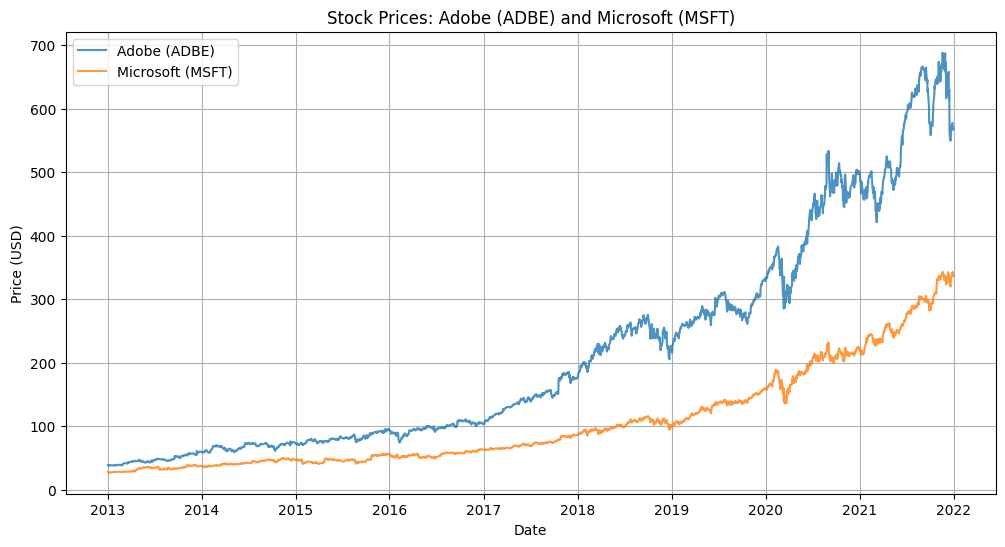

In [3]:
# Plot the prices
plt.figure(figsize=(12, 6))
plt.plot(adbe_prices, label='Adobe (ADBE)', linestyle='-', alpha=0.8)
plt.plot(msft_prices, label='Microsoft (MSFT)', linestyle='-', alpha=0.8)

plt.title('Stock Prices: Adobe (ADBE) and Microsoft (MSFT)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

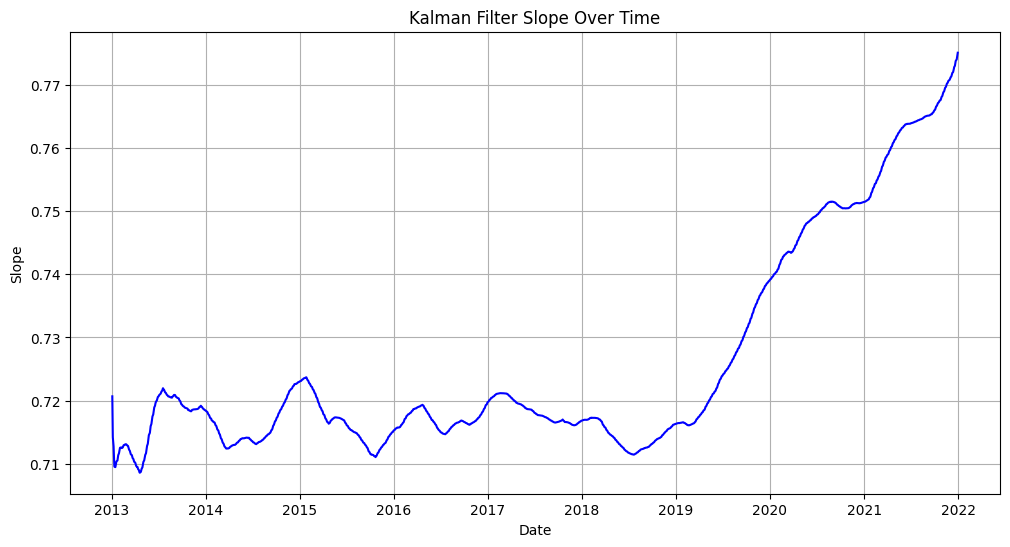

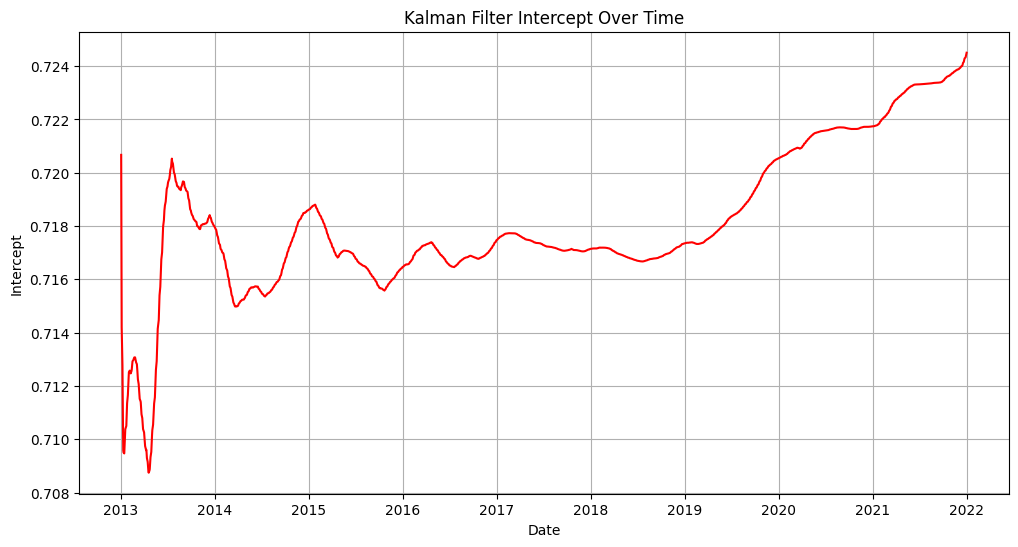

In [4]:
# Prepare the observation matrix
obs_mat = sm.add_constant(np.log(data['ADBE']).values, prepend=False)[:, np.newaxis]

# Define the Kalman Filter
kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,
    initial_state_mean=np.ones(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=0.5,
    transition_covariance=0.000001 * np.eye(2)
)

# Apply the Kalman Filter
state_means, state_covs = kf.filter(np.log(data['MSFT']).values)
slope = state_means[:, 0]  # Extract slope
intercept = state_means[:, 1]  # Extract intercept

# Plot slope
plt.figure(figsize=(12, 6))
plt.plot(data['MSFT'].index, slope, color='b')
plt.title('Kalman Filter Slope Over Time')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.grid(True)
plt.show()

# Plot intercept
plt.figure(figsize=(12, 6))
plt.plot(data['MSFT'].index, intercept, color='r')
plt.title('Kalman Filter Intercept Over Time')
plt.xlabel('Date')
plt.ylabel('Intercept')
plt.grid(True)
plt.show()

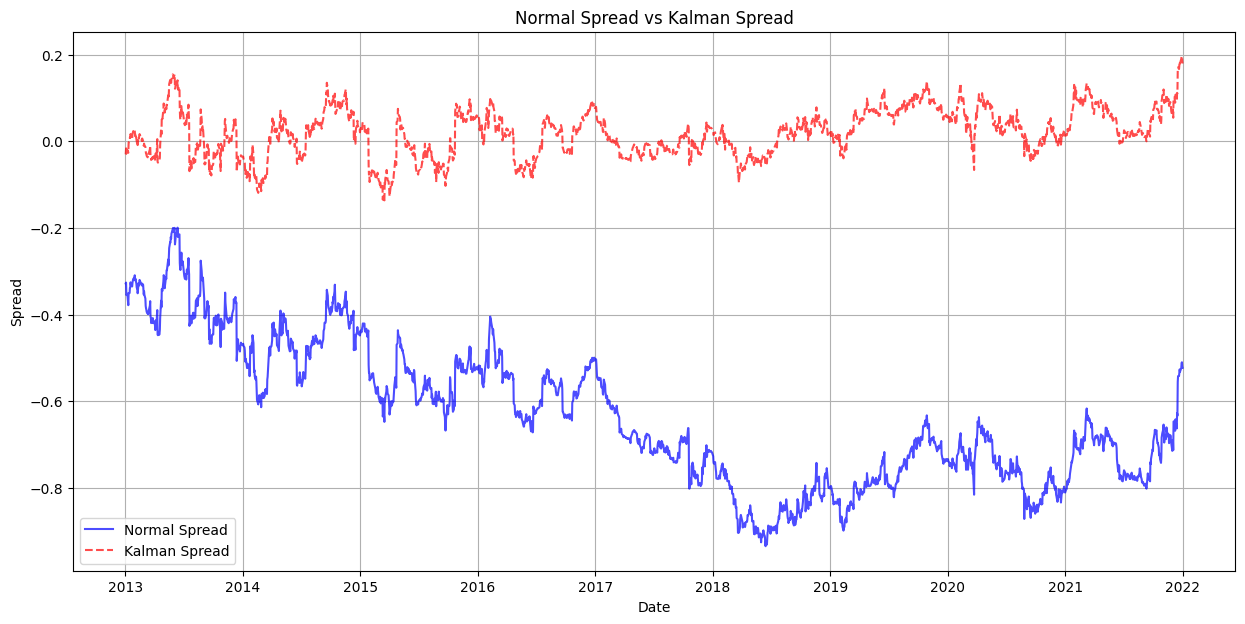

In [5]:
# Calculate the Kalman spread
kl_spread = np.log(data['MSFT']) - np.log(data['ADBE']) * slope - intercept

# Plot original spread vs Kalman spread
plt.figure(figsize=(15, 7))
plt.plot(data.index, np.log(data['MSFT']) - np.log(data['ADBE']), label='Normal Spread', color='blue', alpha=0.7)
plt.plot(data.index, kl_spread, label='Kalman Spread', color='red', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Normal Spread vs Kalman Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

### Z-score

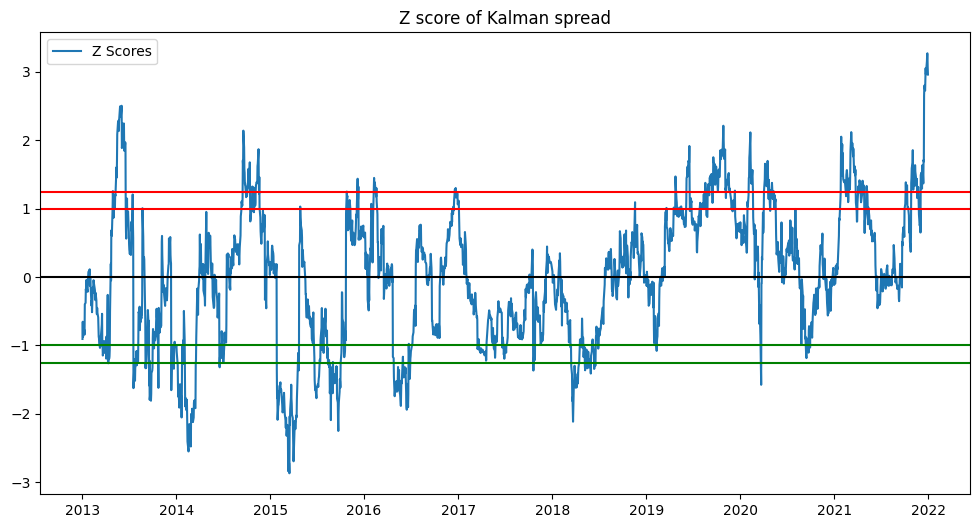

In [6]:
plt.figure(figsize=(12, 6))
df_zscore = (kl_spread - kl_spread.mean())/kl_spread.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Kalman spread')
plt.show()

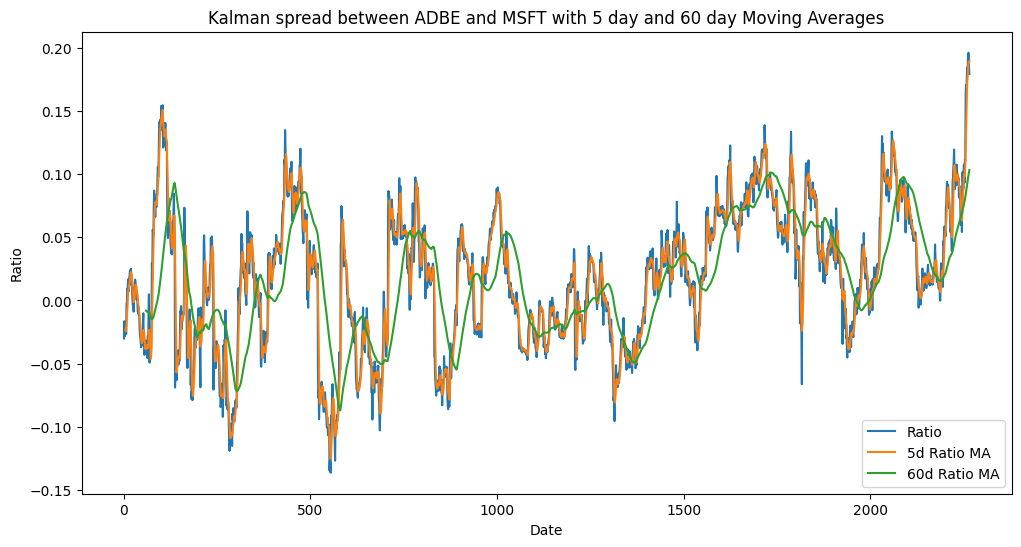

In [7]:
plt.figure(figsize=(12, 6))
kl_spread_mavg5 = kl_spread.rolling(window=5, center=False).mean()
kl_spread_mavg20 = kl_spread.rolling(window=60, center=False).mean()
std_20 = kl_spread.rolling(window=60, center=False).std()
zscore_20_5 = (kl_spread_mavg5 - kl_spread_mavg20)/std_20
plt.plot( kl_spread.values)
plt.plot( kl_spread_mavg5.values)
plt.plot( kl_spread_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Kalman spread between ADBE and MSFT with 5 day and 60 day Moving Averages')
plt.show()

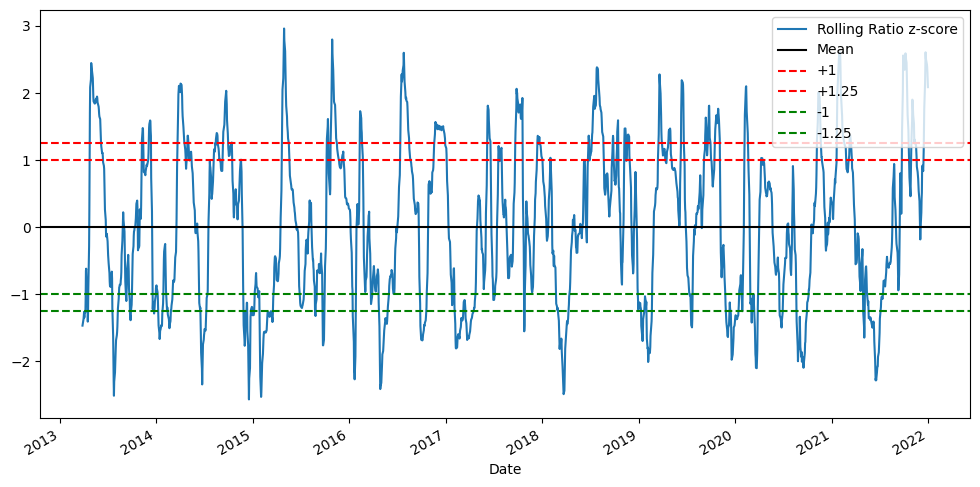

In [8]:
plt.figure(figsize=(12, 6))
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

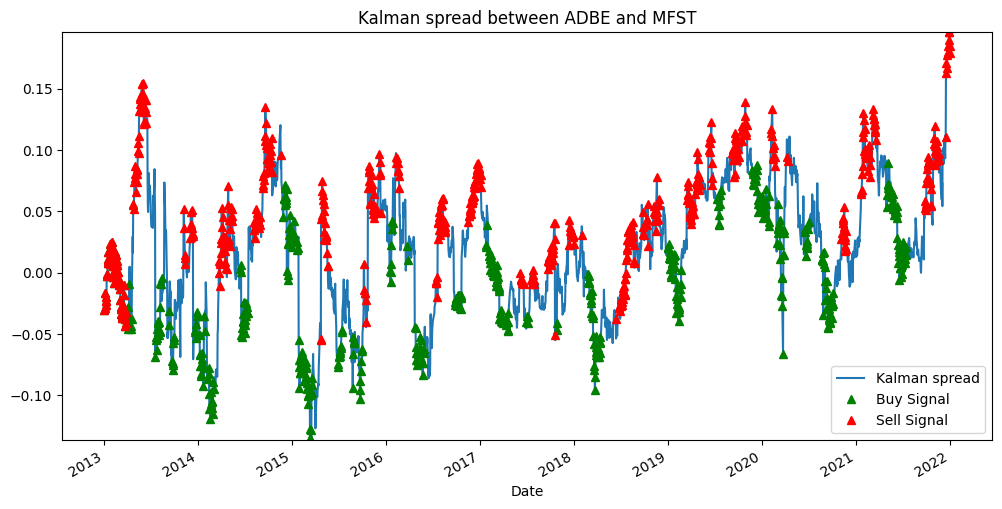

In [9]:
plt.figure(figsize=(12, 6))
kl_spread.plot()
buy = kl_spread.copy()
sell = kl_spread.copy()
buy[zscore_20_5>-1] = None
sell[zscore_20_5<1] = None
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, kl_spread.min(), kl_spread.max()))
plt.legend(['Kalman spread', 'Buy Signal', 'Sell Signal'])
plt.title('Kalman spread between ADBE and MFST')
plt.show()

In [14]:
# Define thresholds for buy/sell signals
buy_threshold = -1
sell_threshold = 1
# Create the Signal column
data['Signal'] = 'Hold'  # Default signal
data.loc[zscore_20_5 < buy_threshold, 'Signal'] = 'Buy'  # Buy Signal
data.loc[zscore_20_5 > sell_threshold, 'Signal'] = 'Sell'  # Sell Si

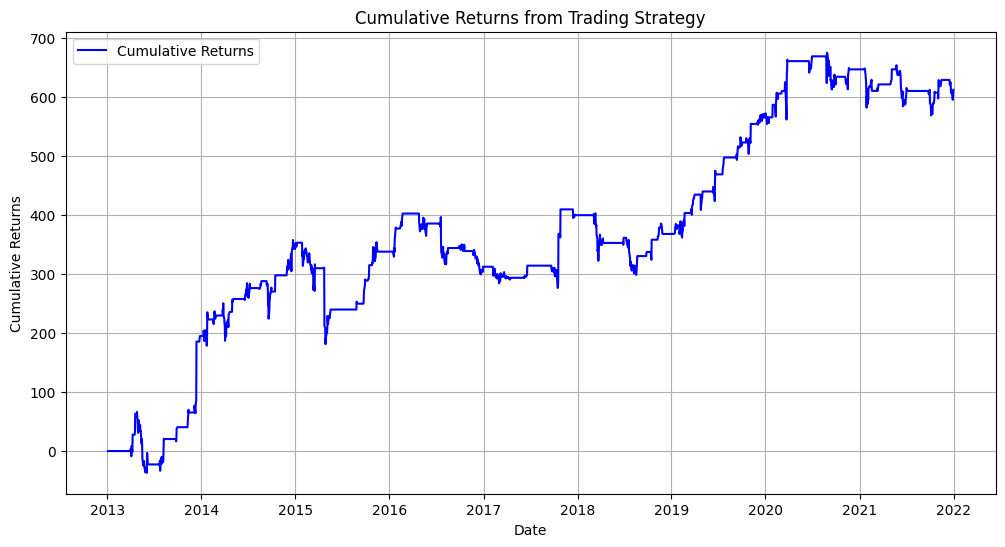

In [18]:
def backtest_strategy(data, kl_spread, zscore_20_5, buy_threshold=-1.25, sell_threshold=1.25):

    # Initialize positions: 1 for long, -1 for short, 0 for neutral
    positions = np.zeros(len(data))
    positions[zscore_20_5 < buy_threshold] = 1  # Long when z-score is below buy threshold
    positions[zscore_20_5 > sell_threshold] = -1  # Short when z-score is above sell threshold

    # Calculate daily returns of the spread
    spread_returns = kl_spread.diff().fillna(0)

    # Calculate strategy returns
    strategy_returns = positions[:-1] * spread_returns[1:]

    # Calculate cumulative returns
    cumulative_returns = np.cumsum(strategy_returns)

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[1:], cumulative_returns*1000, label='Cumulative Returns', color='blue')
    plt.title('Cumulative Returns from Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    return cumulative_returns

# Example usage of the function
cumulative_returns = backtest_strategy(
    data=data,
    kl_spread=kl_spread,
    zscore_20_5=zscore_20_5,
    buy_threshold=-1.25,
    sell_threshold=1.25
)
